In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
# Obtenido de E. McKiernan: https://github.com/emckiernan/electrophys/

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 16 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 18 # fontsize for figure titles
plt.rcParams['font.size'] = 14 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.4 # line width for plotting

In [3]:
# Se baso en la siguiente pagina web: https://realpython.com/python-csv/
def leer_archivo(nombre, n=999):
    datos_rojo = []
    indices_rojo = []
    datos_infrarrojo = []
    indices_infrarrojo = []
    indicador = 2
    
    with open(nombre) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        i = 0
        
        for row in csv_reader:
            if row==[]: #Problema al leer el archivo si el primer elemento esta vacio
                continue
    
            #Identifica si está el led rojo o infrarrojo prendido
            if row[0]=='1':
                indicador = 1 # infrarrojo prendido
            elif row[0]=='3':
                indicador = 3 # rojo prendido
            
            #Guarda los datos en el arreglo correspondiente
            if indicador==1 and row[0]!='1':
                datos_infrarrojo.append(row[0])
                indices_infrarrojo.append(i)

            elif indicador==3 and row[0]!='3':
                datos_rojo.append(row[0])
                indices_rojo.append(i)
   
            i += 1

    return [datos_infrarrojo, indices_infrarrojo, datos_rojo, indices_rojo]

In [4]:
#Encuentra indices seguidos para ponerlos en un arreglo que obtanga maximo y minimo
def max_mins(datos, indices):
    arreglo_sup = []
    maximos = []
    minimos = []
    
    for i in range(len(indices)-1):
        if indices[i+1] == indices[i]+1: #Para cada indice seguido
            arreglo_sup.append(int(datos[i])) #agrega un nuevo elemento
        else:
            arreglo_sup.append(int(datos[i])) #agrega el ultimo elemento
            maximo, minimo = int(max(np.array(arreglo_sup))), int(min(np.array(arreglo_sup))) #saca el maximo y minimo
            maximos.append(maximo)
            minimos.append(minimo)
            arreglo_sup = []
            
    return [maximos, minimos]

In [5]:
def oximetria_a_la_italiana(datos_infrarojo, indices_infrarrojo, datos_rojo, indices_rojo):
    maximos_rojo, minimos_rojo = max_mins(datos_rojo, indices_rojo)
    maximos_infrarrojo, minimos_infrarrojo = max_mins(datos_infrarojo, indices_infrarrojo)
    
    while len(maximos_rojo) != len(maximos_infrarrojo): # Si hubo un número destinto de ciclos rojo/IR
        if len(maximos_rojo) > len(maximos_infrarrojo): # Más ciclos rojo
            maximos_rojo = maximos_rojo[1:] #Quitarle un elemento al rojo
            minimos_rojo = minimos_rojo[1:]
        
        elif len(maximos_rojo) < len(maximos_infrarrojo): # Más ciclos IR
            maximos_infrarrojo = maximos_infrarrojo[1:] #Quitarle un elemento al rojo
            minimos_infrarrojo = minimos_infrarrojo[1:]
            
    # Las cadenas ya son del mismo tamaño
    oximetria = np.zeros(len(maximos_rojo))
    for i in range(len(maximos_rojo)):
        numerador = (maximos_rojo[i]-minimos_rojo[i])/minimos_rojo[i]
        denominador = (maximos_infrarrojo[i]-minimos_infrarrojo[i])/minimos_infrarrojo[i]
        oximetria[i] = numerador/denominador*100
    return oximetria

In [6]:
def promed(datos):
    acumulador = 0
    for i in range(len(datos)):
        acumulador += int(datos[i])
    return acumulador/len(datos)

In [7]:
#Encuentra promedio, desviacion estandar por bloques de indices seguidos y desviacion estandar total
def promedio_funcion(datos, indices):
    arreglo_sup = []
    promedios = []
    desviacion_estandar = []
    todos_los_valores = []
    contador_excepcion = 0
    
    for i in range(len(indices)-1):
        todos_los_valores.append(int(datos[i])) #agrega un nuevo elemento
            
        if indices[i+1] == indices[i]+1: #Para cada indice seguido
            arreglo_sup.append(int(datos[i])) #agrega un nuevo elemento
            contador_excepcion += 1
            
        else:
            if contador_excepcion <= 10:
                # Hay muy pocos indices para calcular ese promedio temporal, entonces lo saltamos!
                arreglo_sup = []
                contador_excepcion = 0
                # Hay que quitar del arreglo los valores que se guardaron chafa
                todos_los_valores = todos_los_valores[:len(todos_los_valores)-contador_excepcion]

                continue
            
            arreglo_sup.append(int(datos[i])) #agrega el ultimo elemento
            # obtiene el proemdio temporal quitando 5 elementos del inicio y final
            # para que no haya tanto ruido en la transicion IR/rojo o rojo/IR
            promedio = promed(np.array(arreglo_sup[5:contador_excepcion-5]))
            promedios.append(promedio)
            desviacion_estandar.append(np.std(arreglo_sup))
            arreglo_sup = []
            contador_expecion = 0
            
    return [promedios, desviacion_estandar, np.std(todos_los_valores)]

In [8]:
def calibrar_phantom(arreglo):
    datos_infrarojo    = arreglo[0]
    indices_infrarrojo = arreglo[1]
    datos_rojo         = arreglo[2]
    indices_rojo       = arreglo[3]
    
    promedios_rojo, desv_est_rojo, desv_est_rojo_total = promedio_funcion(datos_rojo, indices_rojo)
    promedios_infrarrojo, desv_est_infrarrojo, desv_est_infrarrojo_total = promedio_funcion(datos_infrarojo, indices_infrarrojo)
    
    while len(promedios_rojo) != len(promedios_infrarrojo): # Si hubo un número destinto de ciclos rojo/IR
        if len(promedios_rojo) > len(promedios_infrarrojo): # Más ciclos rojo
            promedios_rojo = promedios_rojo[1:] #Quitarle un elemento al rojo
            desv_est_rojo = desv_est_rojo[1:]
        
        elif len(promedios_rojo) < len(promedios_infrarrojo): # Más ciclos IR
            promedios_infrarrojo = promedios_infrarrojo[1:] #Quitarle un elemento al infrarrojo
            desv_est_infrarrojo = desv_est_infrarrojo[1:]
            
    # Las cadenas ya son del mismo tamaño
    oximetria = np.zeros(len(promedios_rojo))
    desviacion_estandar = np.zeros(len(promedios_rojo))
    
    for i in range(len(promedios_rojo)): #Recuerde que cada que se prenda o apague el led habrá 40 mediciones
        oximetria[i] = 100*promedios_rojo[i]/promedios_infrarrojo[i]
        raiz = (desv_est_rojo[i]/promedios_rojo[i])**2 + (desv_est_infrarrojo[i]/promedios_infrarrojo[i])**2
        desviacion_estandar[i] = np.sqrt(raiz) #propagacion de la incertidumbre
        
    desv_est_total = np.mean(oximetria)*np.sqrt((desv_est_rojo_total/np.mean(promedios_rojo))**2 + (desv_est_infrarrojo_total/np.mean(promedios_infrarrojo))**2)
    
    return [oximetria, desviacion_estandar, desv_est_total]

In [9]:
# Las entradas de los arreglos corresponden a:
# arreglo[0] son datos_infrarojo
# arreglo[1] son indices_infrarrojo
# arreglo[2] son datos_rojo
# arreglo[3] son indices_rojo

arreglo_ph1 = leer_archivo('phantom1.csv')
arreglo_ph1_rep = leer_archivo('phantom1_rep.csv')
arreglo_ph2 = leer_archivo('phantom2.csv')
arreglo_ph2_rep = leer_archivo('phantom2_rep.csv')

In [10]:
ph1, desv_est_ph1, desv_est_total_ph1 = calibrar_phantom(arreglo_ph1)
x = [2*i for i in range(len(ph1))]
ph1_promedio = np.mean(ph1)

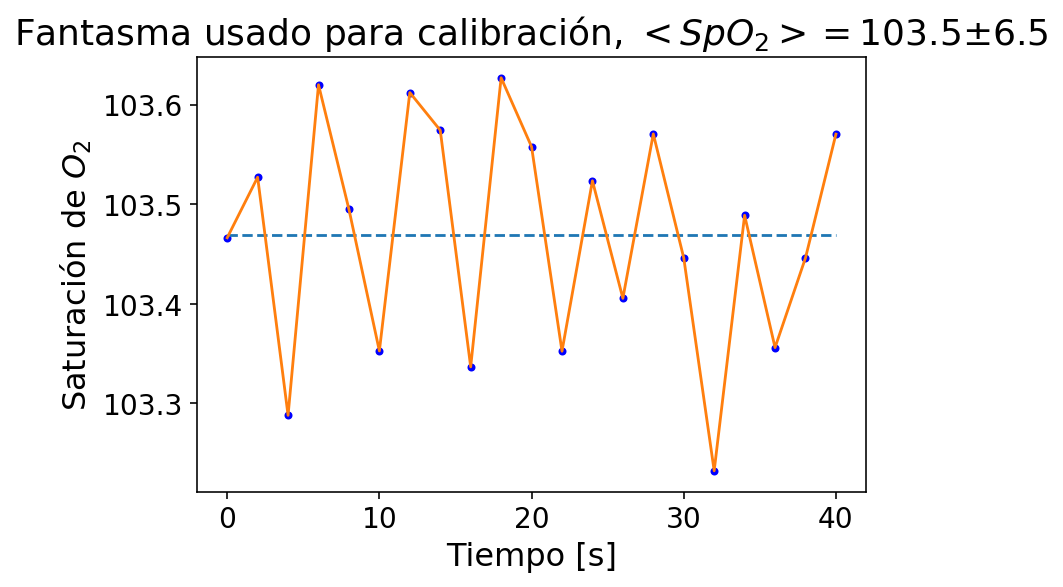

In [11]:
plt.plot(x, ph1, color="b", marker=".", linewidth=0.001)
plt.plot([0, 40], [ph1_promedio, ph1_promedio], linestyle="dashed")
plt.errorbar(x, ph1,yerr=desv_est_ph1)
plt.title("Fantasma usado para calibración, $<SpO_2>=$" + str(round(ph1_promedio, 1))+ "$\pm$" + str(round(desv_est_total_ph1,1)))
plt.ylabel("Saturación de $O_2$")
plt.xlabel("Tiempo [s]")
plt.show()

# Las funciones ``calibrar_phantom`` y ``oximetria_calibrada`` son la misma función, sólo que en la segunda se considera un factor de calibración.

In [12]:
def oximetria_calibrada(arreglo, factor_calibracion = 100/np.mean(ph1)):
    datos_infrarojo    = arreglo[0]
    indices_infrarrojo = arreglo[1]
    datos_rojo         = arreglo[2]
    indices_rojo       = arreglo[3]
    
    promedios_rojo, desv_est_rojo, desv_est_rojo_total = promedio_funcion(datos_rojo, indices_rojo)
    promedios_infrarrojo, desv_est_infrarrojo, desv_est_infrarrojo_total = promedio_funcion(datos_infrarojo, indices_infrarrojo)

    while len(promedios_rojo) != len(promedios_infrarrojo): # Si hubo un número destinto de ciclos rojo/IR
        if len(promedios_rojo) > len(promedios_infrarrojo): # Más ciclos rojo
            promedios_rojo = promedios_rojo[1:] #Quitarle un elemento al rojo
            desv_est_rojo = desv_est_rojo[1:]
        
        elif len(promedios_rojo) < len(promedios_infrarrojo): # Más ciclos IR
            promedios_infrarrojo = promedios_infrarrojo[1:] #Quitarle un elemento al infrarrojo
            desv_est_infrarrojo = desv_est_infrarrojo[1:]
            
    # Las cadenas ya son del mismo tamaño
    oximetria = np.zeros(len(promedios_rojo))
    desviacion_estandar = np.zeros(len(promedios_rojo))
    
    for i in range(len(promedios_rojo)):
        oximetria[i] = 100*factor_calibracion*promedios_rojo[i]/promedios_infrarrojo[i]
        raiz = (desv_est_rojo[i]/promedios_rojo[i])**2 + (desv_est_infrarrojo[i]/promedios_infrarrojo[i])**2
        desviacion_estandar[i] = oximetria[i]*np.sqrt(raiz) #propagacion de la incertidumbre
    
    desv_est_total = np.mean(oximetria)*np.sqrt((desv_est_rojo_total/np.mean(promedios_rojo))**2 + (desv_est_infrarrojo_total/np.mean(promedios_infrarrojo))**2)
    
    return [oximetria, desviacion_estandar, desv_est_total]

In [13]:
ph1_oximetria, desv_est_ph1_oximetria, desv_est_total_ph1_oximetria = oximetria_calibrada(arreglo_ph1)
x_ph1 = [2*i for i in range(len(ph1_oximetria))]
ph1_oximetria_promedio = np.mean(ph1_oximetria)

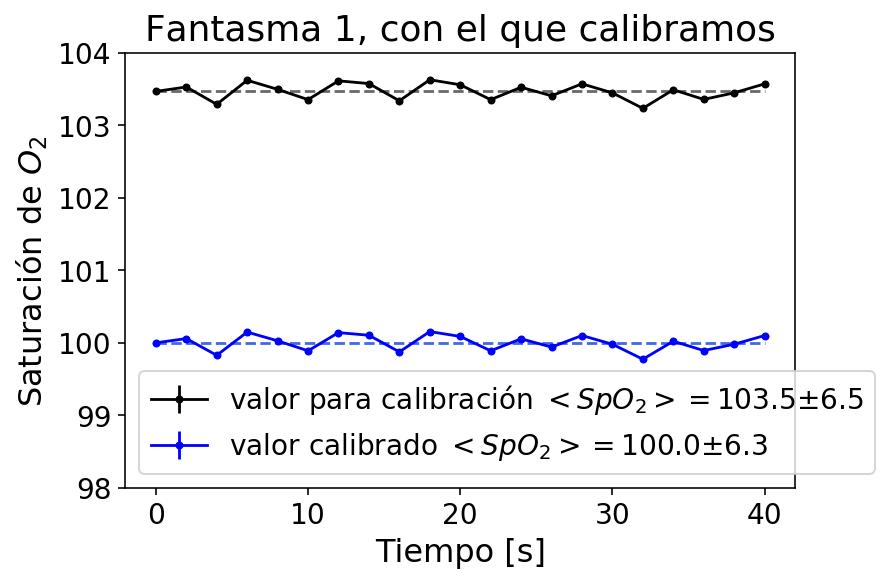

In [14]:
etiqueta_1 = "valor para calibración $<SpO_2>=$" + str(round(ph1_promedio, 1))+ "$\pm$" + str(round(desv_est_total_ph1,1))
plt.plot([0, x_ph1[-1]], [ph1_promedio, ph1_promedio], linestyle="dashed", color ="dimgrey")
plt.errorbar(x, ph1,yerr=desv_est_ph1, color="k", marker=".", label = etiqueta_1)

etiqueta_2 = "valor calibrado $<SpO_2>=$" + str(round(ph1_oximetria_promedio, 1))+ "$\pm$" + str(round(desv_est_total_ph1_oximetria,1))
plt.plot([0, x_ph1[-1]], [ph1_oximetria_promedio, ph1_oximetria_promedio], linestyle="dashed", color ="royalblue")
plt.errorbar(x_ph1, ph1_oximetria, yerr=desv_est_ph1, color="b", marker=".", label=etiqueta_2)

plt.title("Fantasma 1, con el que calibramos")
plt.ylabel("Saturación de $O_2$")
plt.xlabel("Tiempo [s]")
plt.ylim(98, 104)
plt.legend()
plt.show()

In [15]:
ph2, desv_est_ph2, desv_est_total_ph2 = oximetria_calibrada(arreglo_ph2)
x_ph2 = [2*i for i in range(len(ph2))]
ph2_promedio = np.mean(ph2)

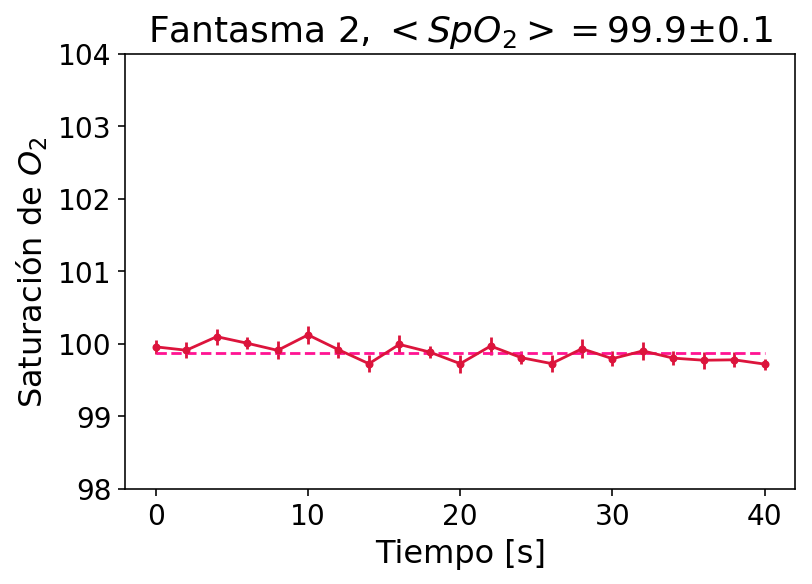

In [16]:
plt.plot([0, x_ph2[-1]], [ph2_promedio, ph2_promedio], linestyle="dashed", color ="deeppink")
plt.errorbar(x_ph2, ph2, yerr=desv_est_ph2, color="crimson", marker=".", label="valor calibrado")
plt.title("Fantasma 2, $<SpO_2>=$" + str(round(ph2_promedio, 1))+ "$\pm$" + str(round(desv_est_total_ph2,1)))
plt.ylabel("Saturación de $O_2$")
plt.xlabel("Tiempo [s]")
plt.ylim(98, 104)
plt.show()

# Sujetos de prueba

In [17]:
def datos_sujeto(nombre_archivo):
    arreglo = leer_archivo(nombre_archivo)
    ox, desv_est, desv_est_total = oximetria_calibrada(arreglo)
    x = [2*i for i in range(len(ox))]
    promedio = int(np.round(np.mean(ox),1))
    
    return [x, promedio, ox, desv_est, int(np.round(desv_est_total))]

In [18]:
def graficar(x, promedio, ox, desv_est, desv_est_total, nombre, colour, sujeto, limitesy=[87,115], n=5):
    
    for i in range(n):
        etiqueta = nombre[i]+" $<SpO_2>$=" + str(promedio[i]) + "$\pm$" + str(desv_est_total[i])
        
        plt.plot([0, x[i][-1]], [promedio[i], promedio[i]], linestyle="dashed", color =colour[i])
        plt.errorbar(x[i], ox[i], yerr=desv_est[i], color=colour[i], marker=".", label=etiqueta)
        
    plt.title(sujeto)
    plt.ylabel("Saturación de $O_2$")
    plt.xlabel("Tiempo [s]")
    plt.ylim(limitesy)
    plt.legend(bbox_to_anchor=(1,0, 0.7, 0),loc="lower right")
    plt.show()
    return None

In [19]:
x_25F, promedio_25F, ox_25F, desv_est_25F, desv_est_total_25F = datos_sujeto('25_F_10pm.csv')
x_26F, promedio_26F, ox_26F, desv_est_26F, desv_est_total_26F = datos_sujeto('26_F_8pm.csv')
x_27F, promedio_27F, ox_27F, desv_est_27F, desv_est_total_27F = datos_sujeto('27_F_8pm.csv')
x_28F, promedio_28F, ox_28F, desv_est_28F, desv_est_total_28F = datos_sujeto('28_F_8pm.csv')
x_29F, promedio_29F, ox_29F, desv_est_29F, desv_est_total_29F = datos_sujeto('29_F_7pm.csv')
x_30F, promedio_30F, ox_30F, desv_est_30F, desv_est_total_30F = datos_sujeto('30_F_9pm.csv')
x_31F, promedio_31F, ox_31F, desv_est_31F, desv_est_total_31F = datos_sujeto('31_F_9pm.csv')

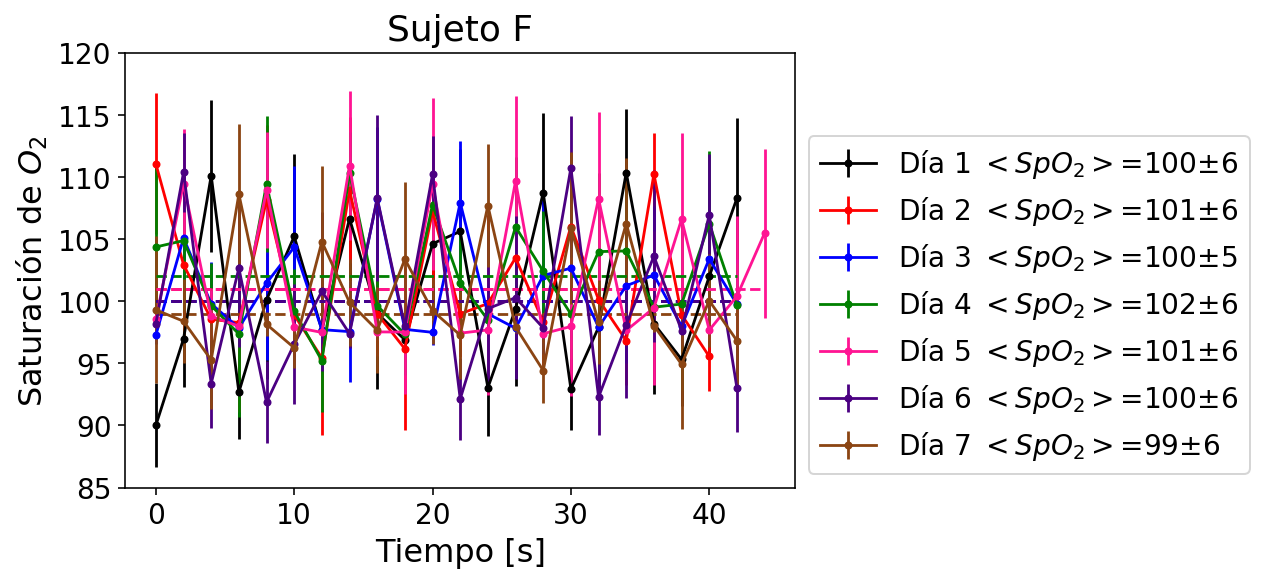

In [20]:
graficar([x_25F, x_26F, x_27F, x_28F, x_29F, x_30F, x_31F],
         [promedio_25F, promedio_26F, promedio_27F, promedio_28F, promedio_29F, promedio_30F, promedio_31F],
         [ox_25F, ox_26F, ox_27F, ox_28F, ox_29F, ox_30F, ox_31F],
         [desv_est_25F, desv_est_26F, desv_est_27F, desv_est_28F, desv_est_29F, desv_est_30F, desv_est_31F],
         [desv_est_total_25F, desv_est_total_26F, desv_est_total_27F, desv_est_total_28F, desv_est_total_29F, desv_est_total_30F, desv_est_total_31F],
         ["Día 1", "Día 2", "Día 3", "Día 4", "Día 5", "Día 6", "Día 7"],
         ["k", "r", "b", "green", "deeppink", "indigo","saddlebrown"],
         "Sujeto F",[85,120], 7)

In [21]:
x_25E, promedio_25E, ox_25E, desv_est_25E, desv_est_total_25E = datos_sujeto('25_E_10pm.csv')
x_26E, promedio_26E, ox_26E, desv_est_26E, desv_est_total_26E = datos_sujeto('26_E_8pm.csv')
x_27E, promedio_27E, ox_27E, desv_est_27E, desv_est_total_27E = datos_sujeto('27_E_8pm.csv')
x_28E, promedio_28E, ox_28E, desv_est_28E, desv_est_total_28E = datos_sujeto('28_E_8pm.csv')
x_29E, promedio_29E, ox_29E, desv_est_29E, desv_est_total_29E = datos_sujeto('29_E_9pm.csv')
x_30E, promedio_30E, ox_30E, desv_est_30E, desv_est_total_30E = datos_sujeto('30_E_9pm.csv')
x_31E, promedio_31E, ox_31E, desv_est_31E, desv_est_total_31E = datos_sujeto('31_E_9pm.csv')

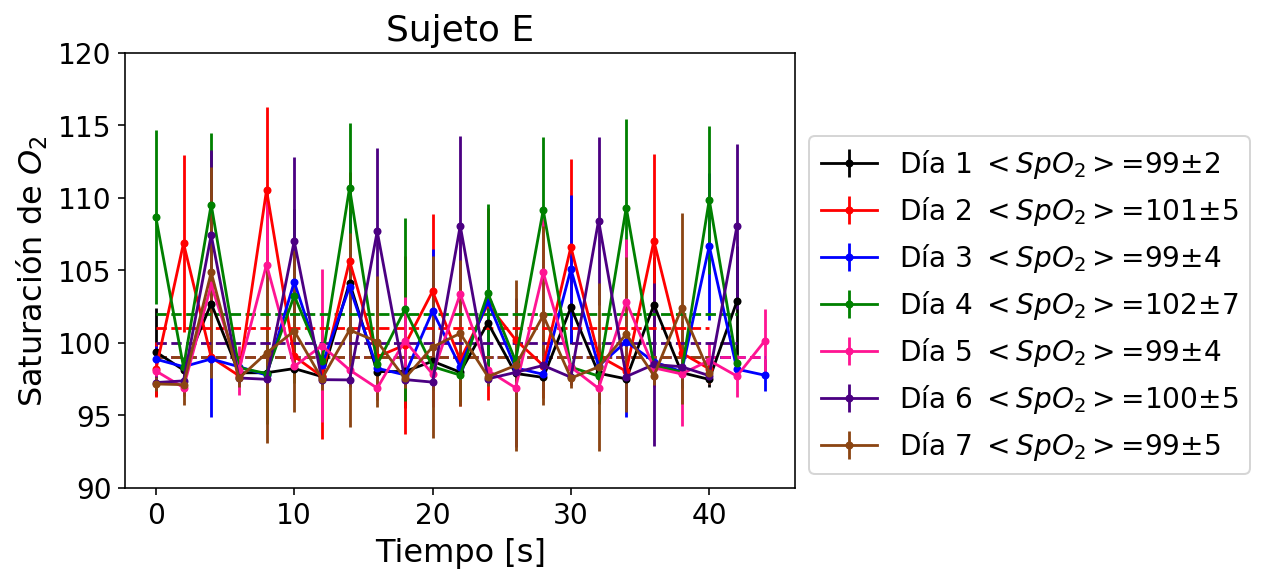

In [22]:
graficar([x_25E, x_26E, x_27E, x_28E, x_29E, x_30E, x_31E],
         [promedio_25E, promedio_26E, promedio_27E, promedio_28E, promedio_29E, promedio_30E, promedio_31E],
         [ox_25E, ox_26E, ox_27E, ox_28E, ox_29E, ox_30E, ox_31E],
         [desv_est_25E, desv_est_26E, desv_est_27E, desv_est_28E, desv_est_29E, desv_est_30E, desv_est_31E],
         [desv_est_total_25E, desv_est_total_26E, desv_est_total_27E, desv_est_total_28E, desv_est_total_29E, desv_est_total_30E, desv_est_total_31E],
         ["Día 1", "Día 2", "Día 3", "Día 4", "Día 5", "Día 6", "Día 7"],
         ["k", "r", "b", "green", "deeppink", "indigo","saddlebrown"],
         "Sujeto E",[90,120], 7)

In [23]:
x_25D, promedio_25D, ox_25D, desv_est_25D, desv_est_total_25D = datos_sujeto('25_D_10pm.csv')
x_26D, promedio_26D, ox_26D, desv_est_26D, desv_est_total_26D = datos_sujeto('26_D_8pm.csv')
x_27D, promedio_27D, ox_27D, desv_est_27D, desv_est_total_27D = datos_sujeto('27_D_8pm.csv')
x_28D, promedio_28D, ox_28D, desv_est_28D, desv_est_total_28D = datos_sujeto('28_D_8pm.csv')
x_29D, promedio_29D, ox_29D, desv_est_29D, desv_est_total_29D = datos_sujeto('29_D_7pm.csv')
x_30D, promedio_30D, ox_30D, desv_est_30D, desv_est_total_30D = datos_sujeto('30_D_9pm.csv')
x_31D, promedio_31D, ox_31D, desv_est_31D, desv_est_total_31D = datos_sujeto('31_D_9pm.csv')

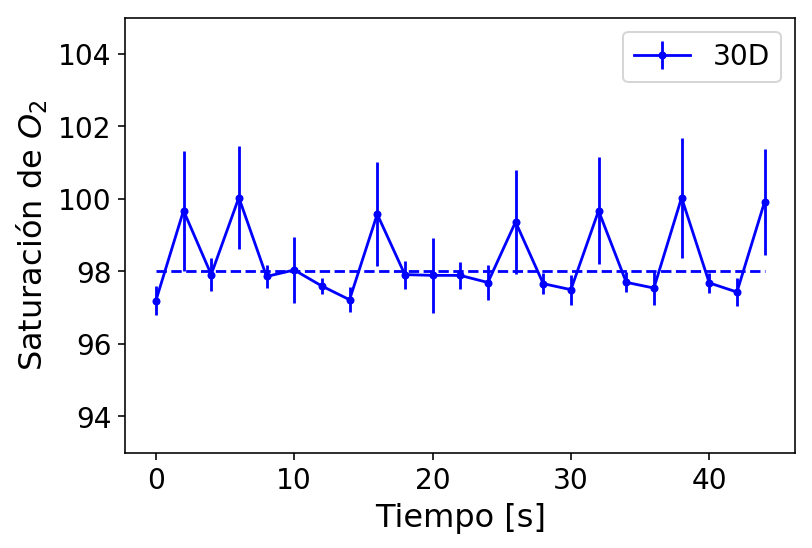

In [35]:
# graficar(x_30D, promedio_30D, ox_30D, desv_est_30D, desv_est_total_30D, "30D", "b", "Sujeto D", [87,115], 1)

etiqueta = "$<SpO_2>$=" + str(promedio_30D) + "$\pm$" + str(desv_est_total_30D)
        
plt.plot([0, x_30D[-1]], [promedio_30D, promedio_30D], linestyle="dashed", color ='b')
plt.errorbar(x_30D, ox_30D, yerr=desv_est_30D, color='b', marker=".", label="30D")
        
# plt.title(sujeto)
plt.ylabel("Saturación de $O_2$")
plt.xlabel("Tiempo [s]")
plt.ylim([93, 105])
plt.legend()
# plt.legend(bbox_to_anchor=(1,0, 0.7, 0),loc="lower right")
plt.show()

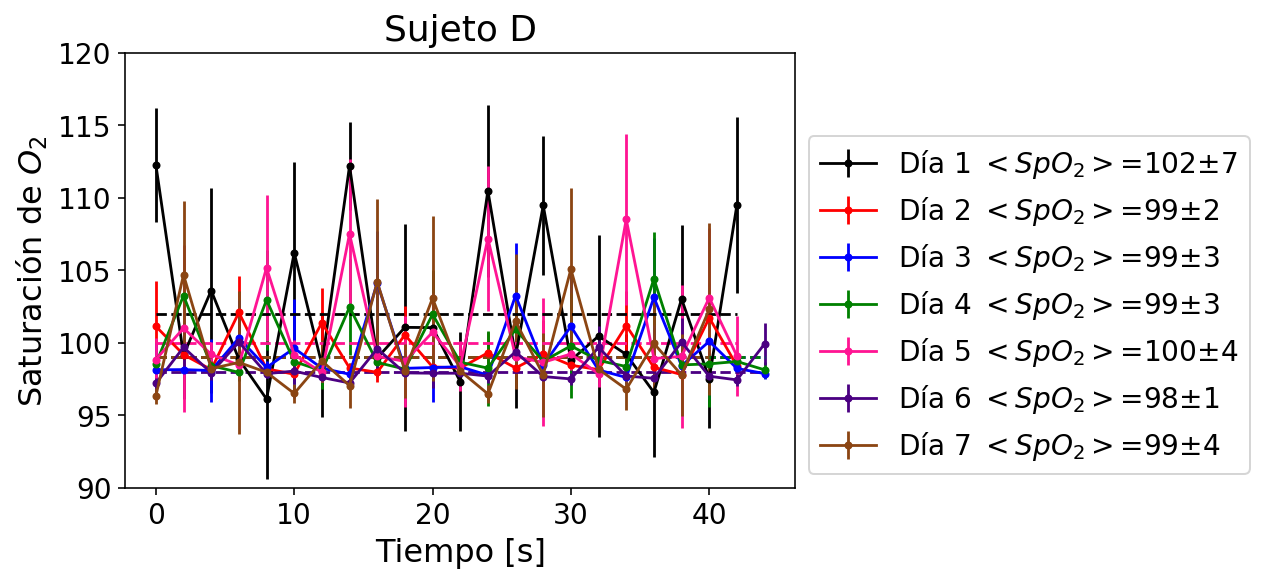

In [24]:
graficar([x_25D, x_26D, x_27D, x_28D, x_29D, x_30D, x_31D],
         [promedio_25D, promedio_26D, promedio_27D, promedio_28D, promedio_29D, promedio_30D, promedio_31D],
         [ox_25D, ox_26D, ox_27D, ox_28D, ox_29D, ox_30D, ox_31D],
         [desv_est_25D, desv_est_26D, desv_est_27D, desv_est_28D, desv_est_29D, desv_est_30D, desv_est_31D],
         [desv_est_total_25D, desv_est_total_26D, desv_est_total_27D, desv_est_total_28D, desv_est_total_29D, desv_est_total_30D, desv_est_total_31D],
         ["Día 1", "Día 2", "Día 3", "Día 4", "Día 5", "Día 6", "Día 7"],
         ["k", "r", "b", "green", "deeppink", "indigo","saddlebrown"],
         "Sujeto D",[90,120], 7)

In [25]:
x_25A, promedio_25A, ox_25A, desv_est_25A, desv_est_total_25A = datos_sujeto('25_A_10pm.csv')
x_26A, promedio_26A, ox_26A, desv_est_26A, desv_est_total_26A = datos_sujeto('26_A_8pm.csv')
x_27A, promedio_27A, ox_27A, desv_est_27A, desv_est_total_27A = datos_sujeto('27_A_8pm.csv')
x_28A, promedio_28A, ox_28A, desv_est_28A, desv_est_total_28A = datos_sujeto('28_A_8pm.csv')
x_29A, promedio_29A, ox_29A, desv_est_29A, desv_est_total_29A = datos_sujeto('29_A_7pm.csv')
x_29A_RF, promedio_29A_RF, ox_29A_RF, desv_est_29A_RF, desv_est_total_29A_RF = datos_sujeto('29_A_7pm_respirando_fuerte.csv')
x_30A, promedio_30A, ox_30A, desv_est_30A, desv_est_total_30A = datos_sujeto('30_A_9pm.csv')
x_31A, promedio_31A, ox_31A, desv_est_31A, desv_est_total_31A = datos_sujeto('31_A_9pm.csv')

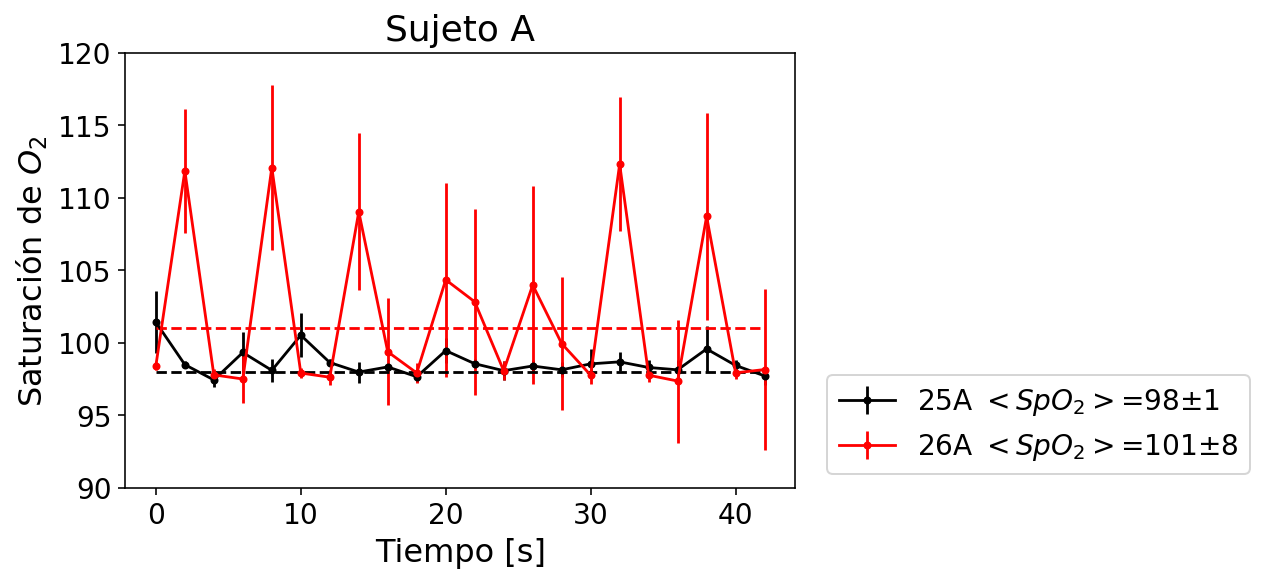

In [26]:
graficar([x_25A, x_26A],
         [promedio_25A, promedio_26A],
         [ox_25A, ox_26A],
         [desv_est_25A, desv_est_26A],
         [desv_est_total_25A, desv_est_total_26A],
         ["25A", "26A"],
         ["k", "r", "b", "crimson", "indigo","green","saddlebrown", "chocolate", "lawngreen"],
         "Sujeto A",
         [90,120],
         2)

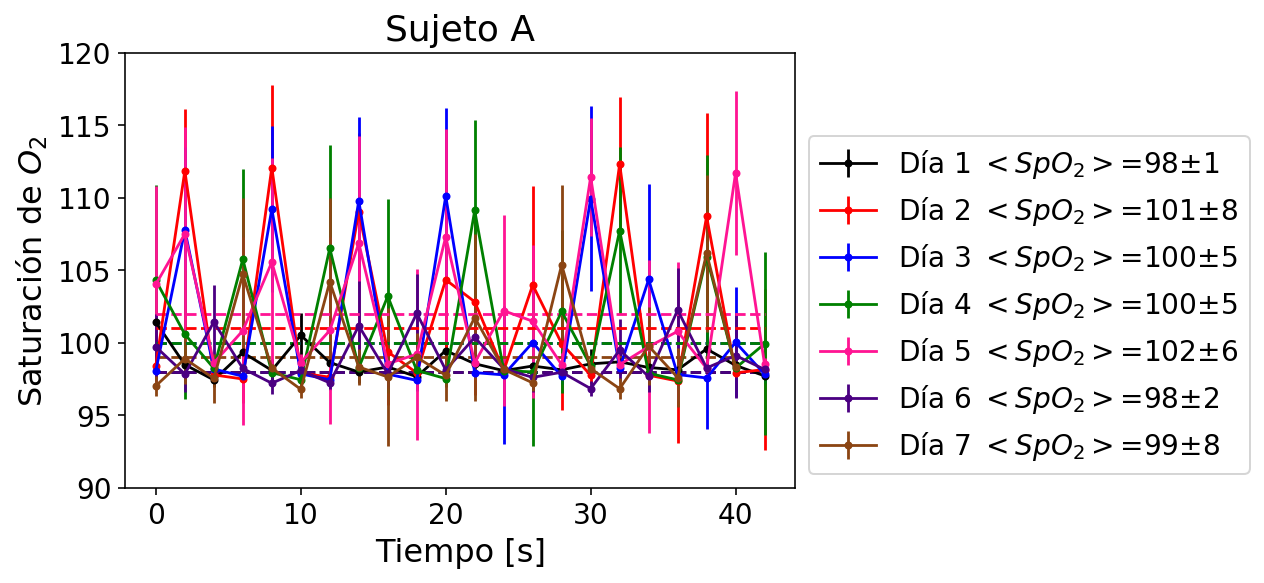

In [27]:
graficar([x_25A, x_26A, x_27A, x_28A, x_29A, x_30A, x_31A],
         [promedio_25A, promedio_26A, promedio_27A, promedio_28A, promedio_29A, promedio_30A, promedio_31A],
         [ox_25A, ox_26A, ox_27A, ox_28A, ox_29A, ox_30A, ox_31A],
         [desv_est_25A, desv_est_26A, desv_est_27A, desv_est_28A, desv_est_29A, desv_est_30A, desv_est_31A],
         [desv_est_total_25A, desv_est_total_26A, desv_est_total_27A, desv_est_total_28A, desv_est_total_29A, desv_est_total_30A, desv_est_total_31A],
         ["Día 1", "Día 2", "Día 3", "Día 4", "Día 5", "Día 6", "Día 7"],
         ["k", "r", "b", "green", "deeppink", "indigo","saddlebrown"],
         "Sujeto A", [90,120], 7)

# Comparación con oxímetro comercial

Beijing Choice Electronic Technology

Especificaciones:
 - Resolución $\pm 1$% $SpO_2$
 - Precisión de medida $SpO_2$: 70-100%, $\pm 2$ dígitos

In [39]:
ox_comercial_25A = [93, 94, 95, 96]
ox_comercial_25D = [96, 97, 96, 97]
ox_comercial_25E = [96, 95, 96, 95, 96]
ox_comercial_25F = [93]

ox_comercial_26A = [94, 93, 94, 95, 96, 95, 94, 95]
ox_comercial_26D = [95, 96, 97, 98, 97, 96, 95]
ox_comercial_26E = [95, 95, 95, 96]
ox_comercial_26F = [95, 94, 95]

ox_comercial_27A = [94, 93, 92, 93, 94, 95, 95]
ox_comercial_27D = [95, 96, 95, 94, 95, 94]
ox_comercial_27E = [96, 97, 96, 97]
ox_comercial_27F = [95, 94, 95, 94, 95, 94]

ox_comercial_28A = [95, 94, 93, 94, 95, 94] #Temperatura de 29.4
ox_comercial_28D = [98, 97, 98, 97, 98, 97, 98] #Temperatura de 30.5
ox_comercial_28E = [94, 93, 94, 95] #circa 48 s #Temperatura de 29.6
ox_comercial_28F = [95, 94, 95, 94, 95] #circa 48.5 s #Temperatura de 30.6

T28A = 29.4
T28D = 30.5
T28E = 29.6
T28F = 30.6

ox_comercial_29A = [96, 95, 96, 95]
ox_comercial_29D = [96, 97, 96, 95, 94, 93] #Temperatura de 29.3
ox_comercial_29E = [97, 96, 95] 
ox_comercial_29F = [93, 94, 93, 94, 95, 94] #Temperatura de 29.9

T29A = 28.4
T29D = 29.3
T29E = 29.1
T29F = 29.9

ox_comercial_30A = [95, 96, 97, 96, 97]
ox_comercial_30D = [96, 95, 94, 93, 92, 91, 90]
ox_comercial_30E = [96, 95] 
ox_comercial_30F = [94, 93, 94, 93, 94]

T30A = 29.4
T30D = 28.8
T30E = 30.1
T30F = 30.1

ox_comercial_31A = [95, 94, 93, 94, 95, 96, 97, 98]
ox_comercial_31D = [97, 96, 94, 95]
ox_comercial_31E = [94, 95, 94, 95, 94] 
ox_comercial_31F = [96, 95, 96, 95]

T31A = 29.3
T31D = 29.3
T31E = 29.2
T31F = 30.1

In [40]:
oxc_25A = int(np.mean(ox_comercial_25A))
oxc_25D = int(np.mean(ox_comercial_25D))
oxc_25E = int(np.mean(ox_comercial_25E))
oxc_25F = int(np.mean(ox_comercial_25F))

oxc_26A = int(np.mean(ox_comercial_26A))
oxc_26D = int(np.mean(ox_comercial_26D))
oxc_26E = int(np.mean(ox_comercial_26E))
oxc_26F = int(np.mean(ox_comercial_26F))

oxc_27A = int(np.mean(ox_comercial_27A))
oxc_27D = int(np.mean(ox_comercial_27D))
oxc_27E = int(np.mean(ox_comercial_27E))
oxc_27F = int(np.mean(ox_comercial_27F))

oxc_28A = int(np.mean(ox_comercial_28A))
oxc_28D = int(np.mean(ox_comercial_28D))
oxc_28E = int(np.mean(ox_comercial_28E))
oxc_28F = int(np.mean(ox_comercial_28F))

oxc_29A = int(np.mean(ox_comercial_29A))
oxc_29D = int(np.mean(ox_comercial_29D))
oxc_29E = int(np.mean(ox_comercial_29E))
oxc_29F = int(np.mean(ox_comercial_29F))

oxc_30A = int(np.mean(ox_comercial_30A))
oxc_30D = int(np.mean(ox_comercial_30D))
oxc_30E = int(np.mean(ox_comercial_30E))
oxc_30F = int(np.mean(ox_comercial_30F))

oxc_31A = int(np.mean(ox_comercial_31A))
oxc_31D = int(np.mean(ox_comercial_31D))
oxc_31E = int(np.mean(ox_comercial_31E))
oxc_31F = int(np.mean(ox_comercial_31F))

In [41]:
# Modificado de: https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.legend.html
# Para agregar una etiqueta arriba de una gráfica de barras

def comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto):

    x = np.arange(len(etiquetas))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(10,8))
    rects1 = ax.bar(x - width/2, promedios_medidos, width, yerr=desv_est_total_medida, label='Ox desarrollado')
    rects2 = ax.bar(x + width/2, oxc, width, yerr=desv_est_comercial, label='Ox comercial')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('$SpO_2$')
    ax.set_xlabel('Día')
    ax.set_title(sujeto)
    ax.set_xticks(x)
    ax.set_xticklabels(etiquetas)
    ax.legend(loc="lower right")

    def autolabel(rects, desv_est):
        """Attach a text label above each bar in *rects*, displaying its height."""
        i=0
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height)+"$\pm$"+str(desv_est[i]),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
            i += 1
    
    autolabel(rects1, desv_est_total_medida)
    autolabel(rects2, desv_est_comercial)

    fig.tight_layout()
    plt.show()
    
    return None

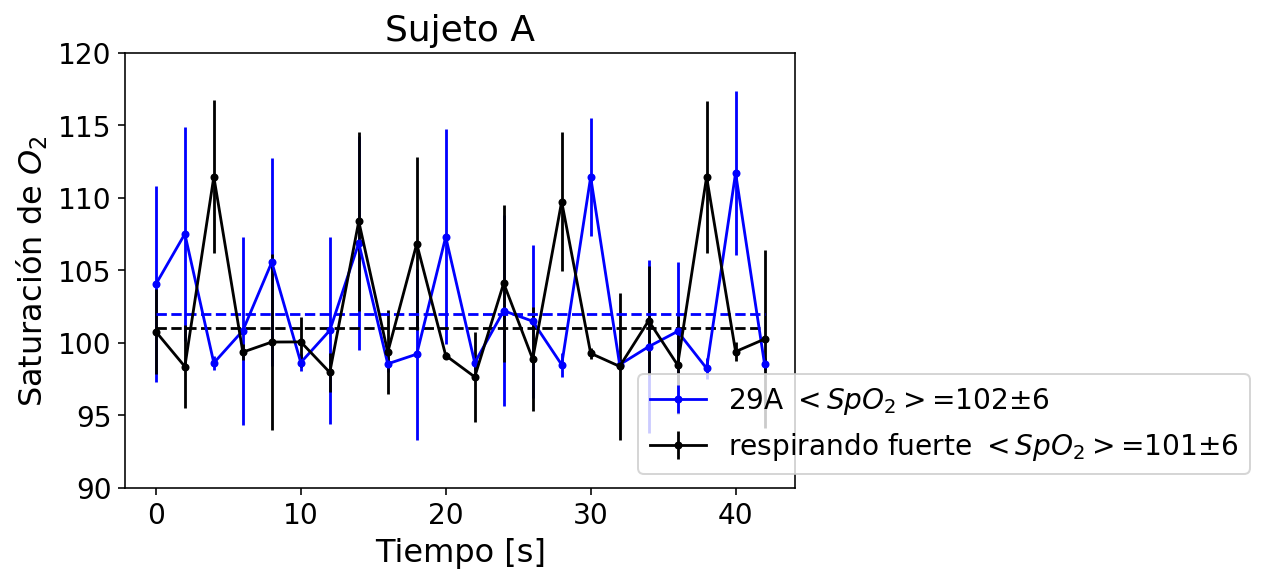

In [42]:
graficar([x_29A, x_29A_RF], [promedio_29A, promedio_29A_RF], [ox_29A, ox_29A_RF],
         [desv_est_29A, desv_est_29A_RF], [desv_est_total_29A, desv_est_total_29A_RF],
         ["29A", "respirando fuerte"], ["b", "k"], "Sujeto A", [90,120], 2)

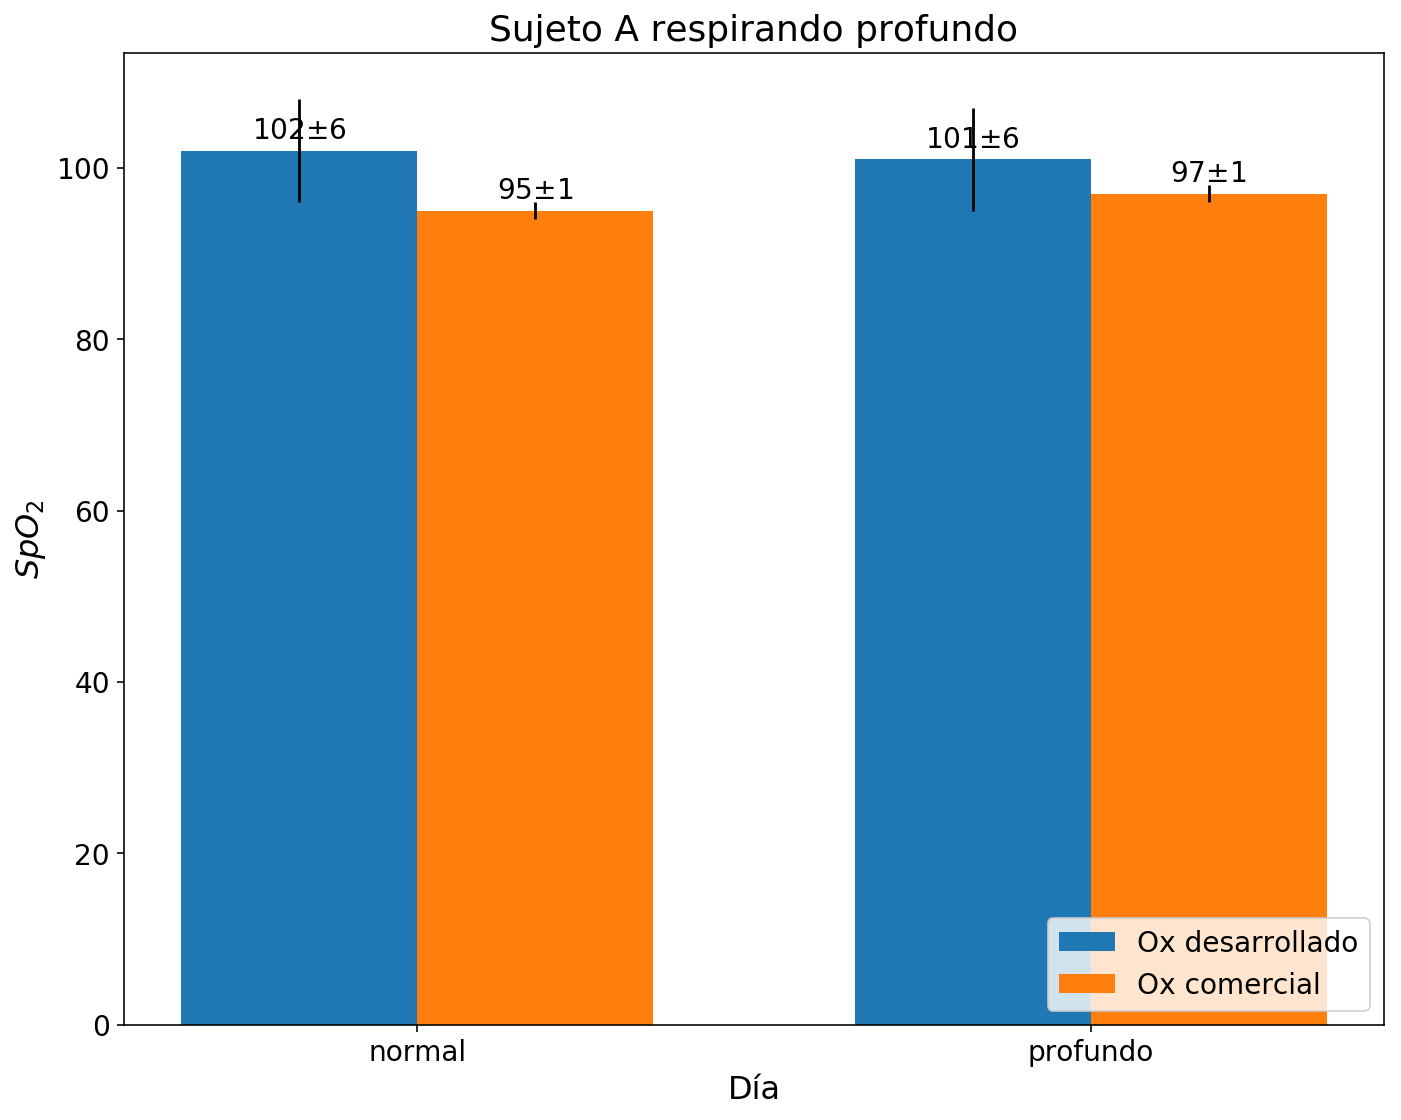

In [43]:
sujeto = "Sujeto A respirando profundo"
etiquetas = ['normal', 'profundo']

ox_comercial_29A = [96, 95, 96, 95]
ox_comercial_29A_RF = [98, 97, 96, 97, 98, 99]
oxc_29A = int(np.mean(ox_comercial_29A))
oxc_29A_RF = int(np.mean(ox_comercial_29A_RF))

promedios_medidos = [promedio_29A, promedio_29A_RF]
desv_est_total_medida = [desv_est_total_29A, desv_est_total_29A_RF]

oxc = [oxc_29A, oxc_29A_RF]
desv_est_comercial = [1, 1]

comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto)

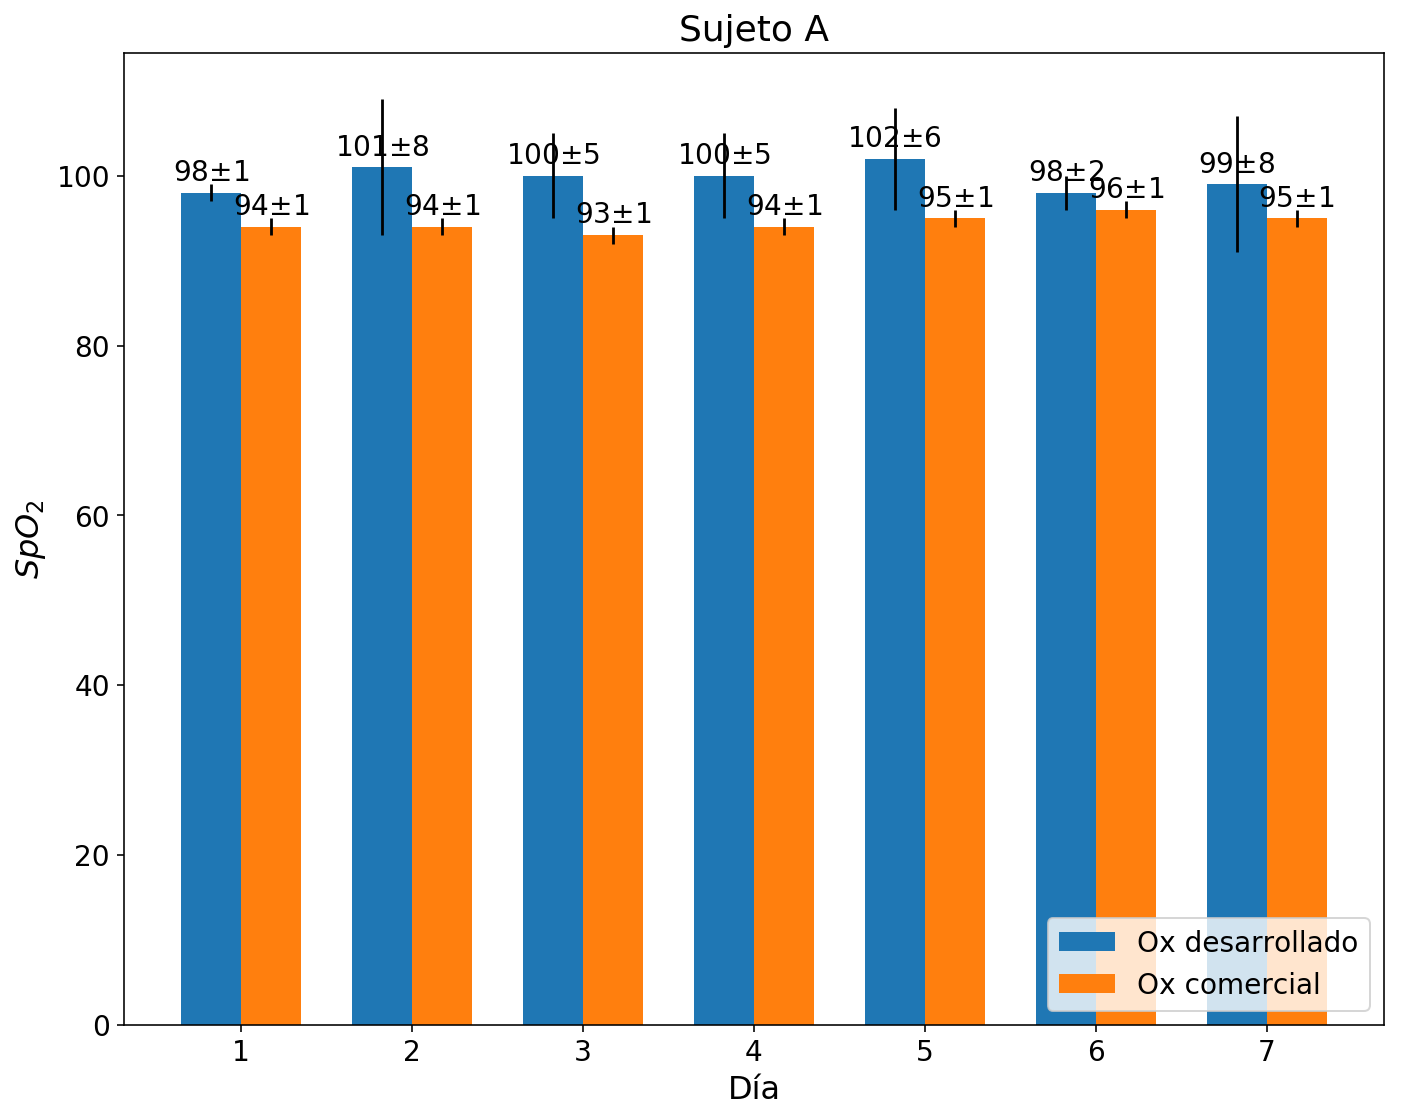

In [44]:
sujeto = "Sujeto A"
etiquetas = ['1', '2', '3', '4', '5', '6', '7']

promedios_medidos = [promedio_25A, promedio_26A, promedio_27A, promedio_28A, promedio_29A, promedio_30A, promedio_31A]
desv_est_total_medida = [desv_est_total_25A, desv_est_total_26A, desv_est_total_27A, desv_est_total_28A, desv_est_total_29A, desv_est_total_30A, desv_est_total_31A]

oxc = [oxc_25A, oxc_26A, oxc_27A, oxc_28A, oxc_29A, oxc_30A, oxc_31A]
desv_est_comercial = [int(np.std(ox_comercial_25A)), 1, int(np.std(ox_comercial_27A)), 1, 1, 1, int(np.std(ox_comercial_31A))]
comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto)

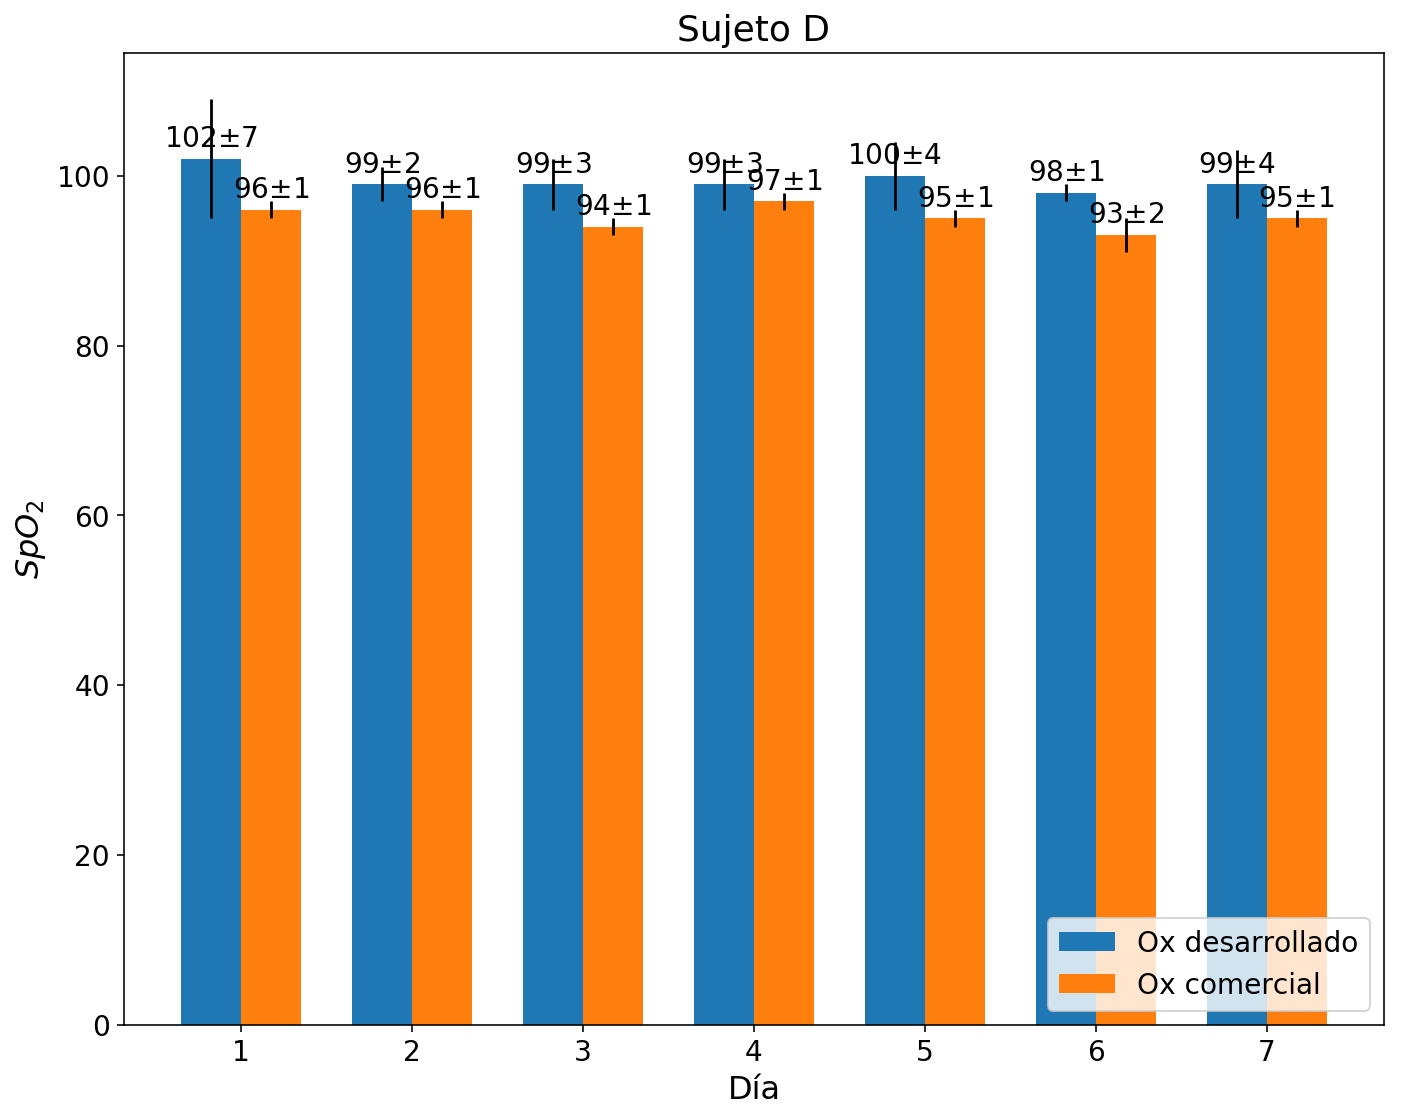

In [45]:
sujeto = "Sujeto D"
etiquetas = ['1', '2', '3', '4', '5', '6', '7']

promedios_medidos = [promedio_25D, promedio_26D, promedio_27D, promedio_28D, promedio_29D, promedio_30D, promedio_31D]
desv_est_total_medida = [desv_est_total_25D, desv_est_total_26D, desv_est_total_27D, desv_est_total_28D, desv_est_total_29D, desv_est_total_30D, desv_est_total_31D]

oxc = [oxc_25D, oxc_26D, oxc_27D, oxc_28D, oxc_29D, oxc_30D, oxc_31D]
desv_est_comercial = [1, 1, 1, 1, int(np.std(ox_comercial_29D)), int(np.std(ox_comercial_30D)), int(np.std(ox_comercial_31D))] #, int(np.std(ox_comercial_27A))

comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto)

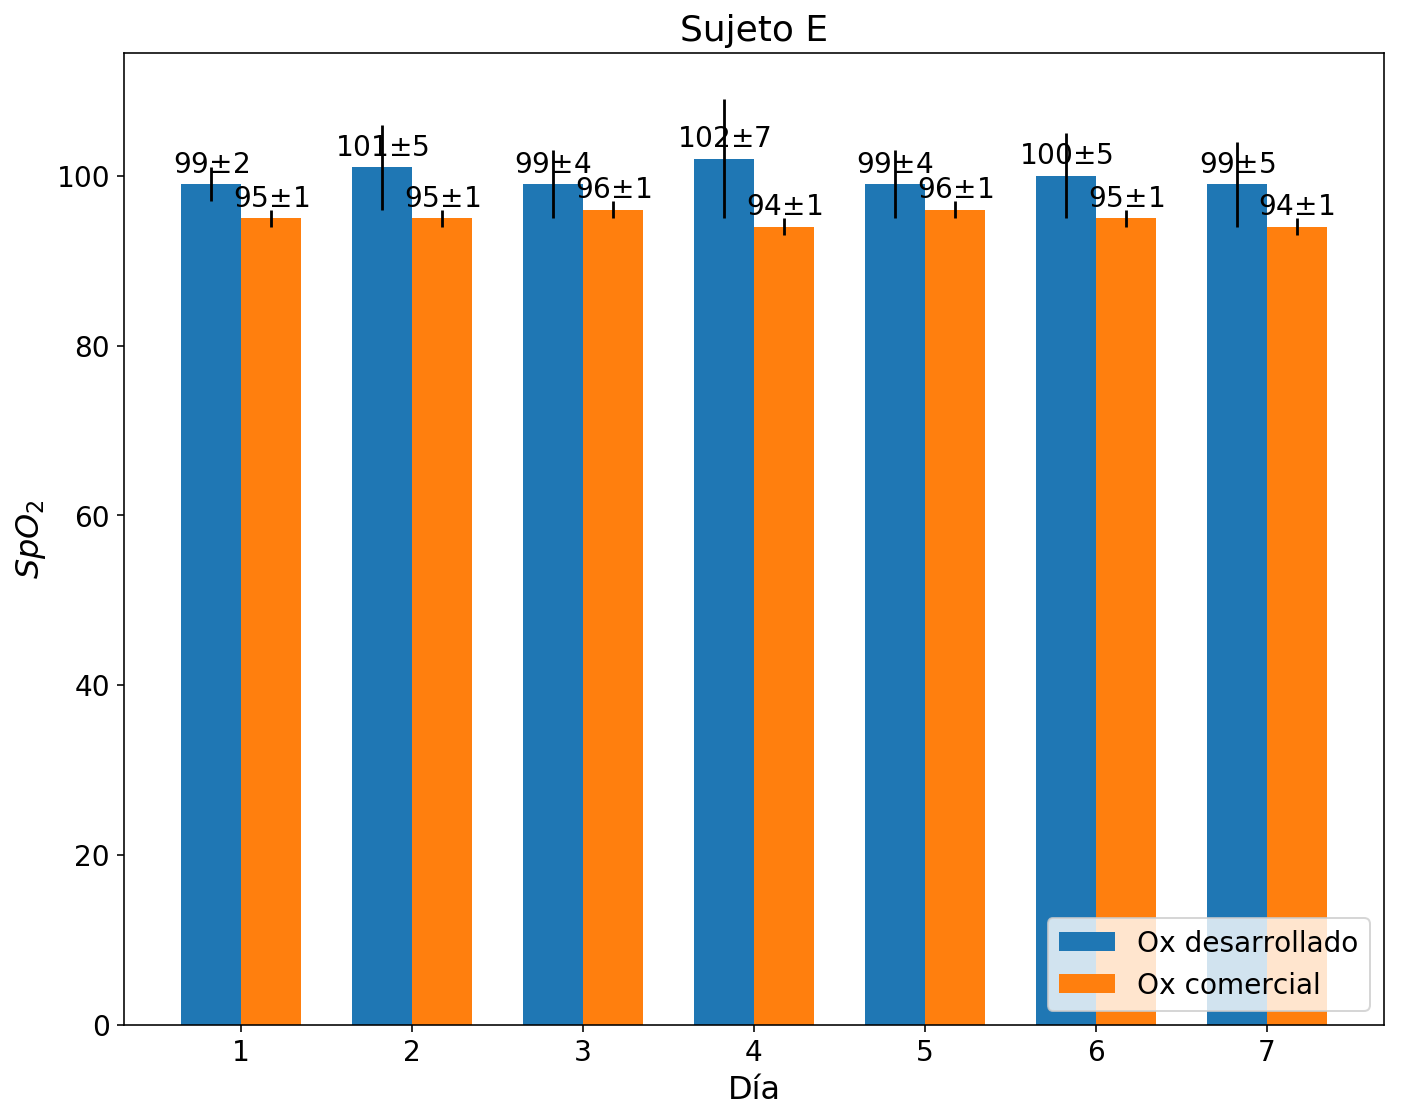

In [46]:
sujeto = "Sujeto E"
etiquetas = ['1', '2', '3', '4', '5', '6', '7']

promedios_medidos = [promedio_25E, promedio_26E, promedio_27E, promedio_28E, promedio_29E, promedio_30E, promedio_31E]
desv_est_total_medida = [desv_est_total_25E, desv_est_total_26E, desv_est_total_27E, desv_est_total_28E, desv_est_total_29E, desv_est_total_30E, desv_est_total_31E]

oxc = [oxc_25E, oxc_26E, oxc_27E, oxc_28E, oxc_29E, oxc_30E, oxc_31E]
desv_est_comercial = [1, 1, 1, 1, 1, 1, 1] #int(np.std(ox_comercial_28E))

comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto)

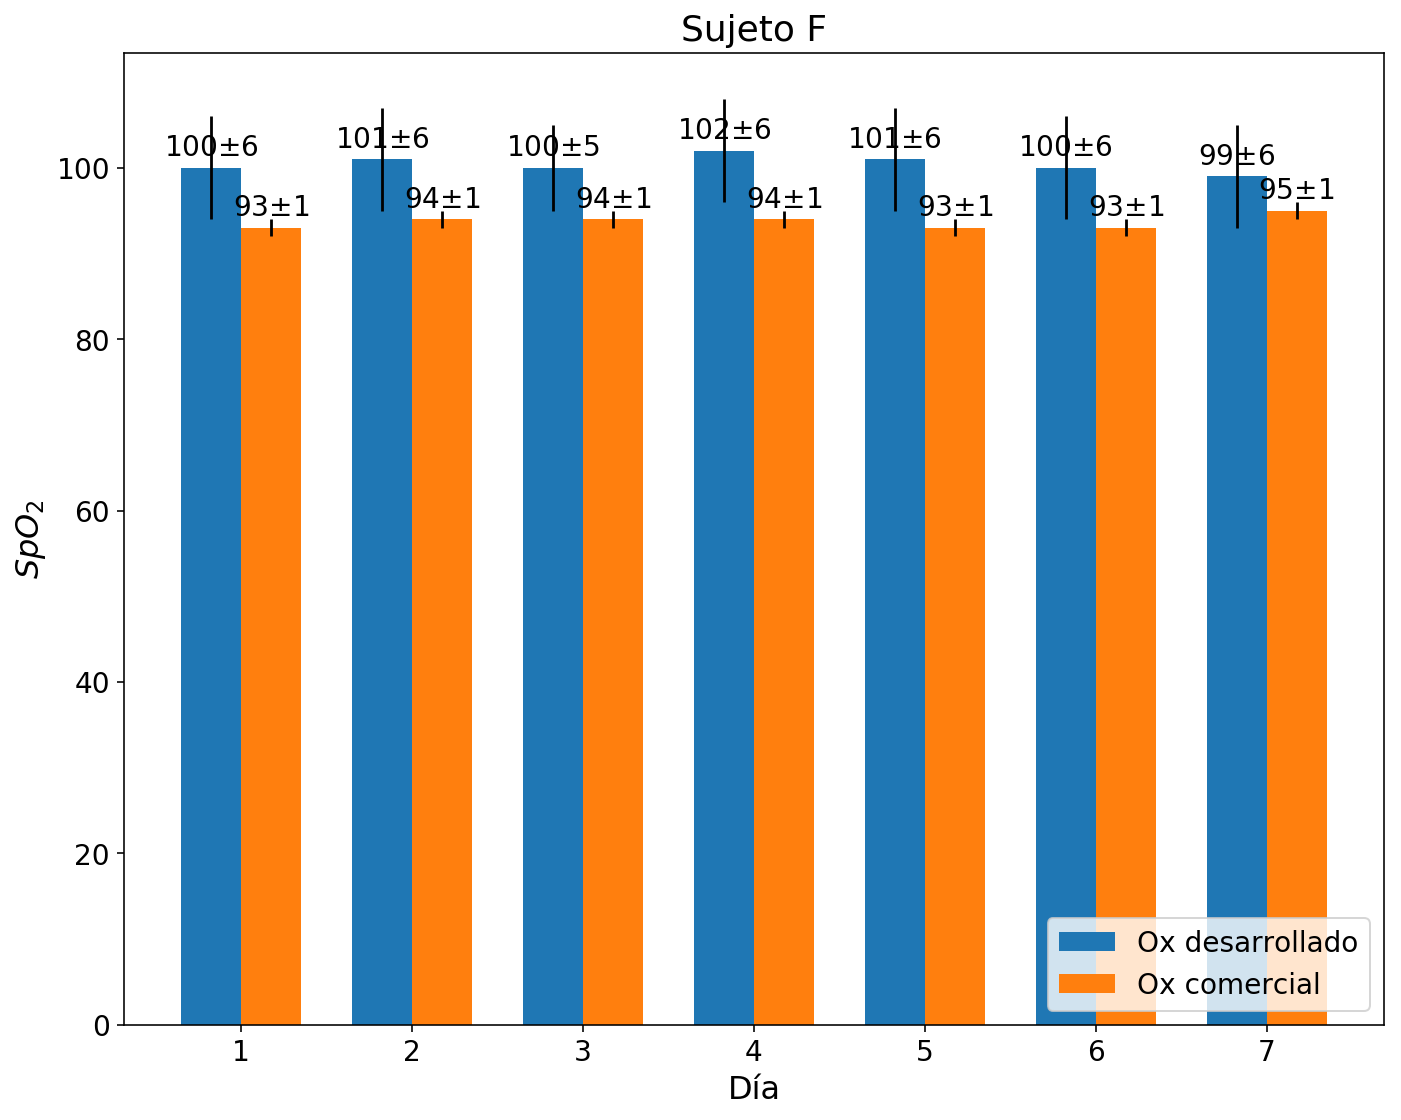

In [47]:
sujeto = "Sujeto F"
etiquetas = ['1', '2', '3', '4', '5', '6', '7']

promedios_medidos = [promedio_25F, promedio_26F, promedio_27F, promedio_28F, promedio_29F, promedio_30F, promedio_31F]
desv_est_total_medida = [desv_est_total_25F, desv_est_total_26F, desv_est_total_27F, desv_est_total_28F, desv_est_total_29F, desv_est_total_30F, desv_est_total_31F]

oxc = [oxc_25F, oxc_26F, oxc_27F, oxc_28F, oxc_29F, oxc_30F, oxc_31F]
desv_est_comercial = [1, 1, 1, 1, 1, 1, 1] #int(np.std(ox_comercial_28F))

comparacion(promedios_medidos, desv_est_total_medida, oxc, desv_est_comercial, etiquetas, sujeto)

# Pruebas estadísticas

In [48]:
promedios_4sujetos = [promedio_25A, promedio_26A, promedio_27A, promedio_28A, promedio_29A, promedio_30A, promedio_31A,
                      promedio_25D, promedio_26D, promedio_27D, promedio_28D, promedio_29D, promedio_30D, promedio_31D,
                      promedio_25E, promedio_26E, promedio_27E, promedio_28E, promedio_29E, promedio_30E, promedio_31E,
                      promedio_25F, promedio_26F, promedio_27F, promedio_28F, promedio_29F, promedio_30F, promedio_31F]
oxc_4sujetos = [oxc_25A, oxc_26A, oxc_27A, oxc_28A, oxc_29A, oxc_30A, oxc_31A,
                oxc_25E, oxc_26E, oxc_27E, oxc_28E, oxc_29E, oxc_30E, oxc_31E,
                oxc_25D, oxc_26D, oxc_27D, oxc_28D, oxc_29D, oxc_30D, oxc_31D,
                oxc_25F, oxc_26F, oxc_27F, oxc_28F, oxc_29F, oxc_30F, oxc_31F]

temperaturas_4sujetos = [T28A, T29A, T30A, T31A,
                         T28D, T29D, T30D, T31D,
                         T28E, T29E, T30E, T31E,
                         T28F, T29F, T30F, T31F]

TA = [T28A, T29A, T30A, T31A]
TD = [T28D, T29D, T30D, T31D]
TE = [T28E, T29E, T30E, T31E]
TF = [T28F, T29F, T30F, T31F]

dia28 =[T28A, T28D, T28E, T28F]
dia29 =[T29A, T29D, T29E, T29F] 
dia30 =[T30A, T30D, T30E, T30F] 
dia31 =[T31A, T31D, T31E, T31F] 

# promA = [promedio_28A, promedio_29A, promedio_30A, promedio_31A]
# desv_est_totalA = [desv_est_total_28A, desv_est_total_29A, desv_est_total_30A, desv_est_total_31A]
etiquetas = ["A", "D", "E", "F"]

In [49]:
minima_temp = min(temperaturas_4sujetos)
maxima_temp = max(temperaturas_4sujetos)

In [50]:
minima_temp

28.4

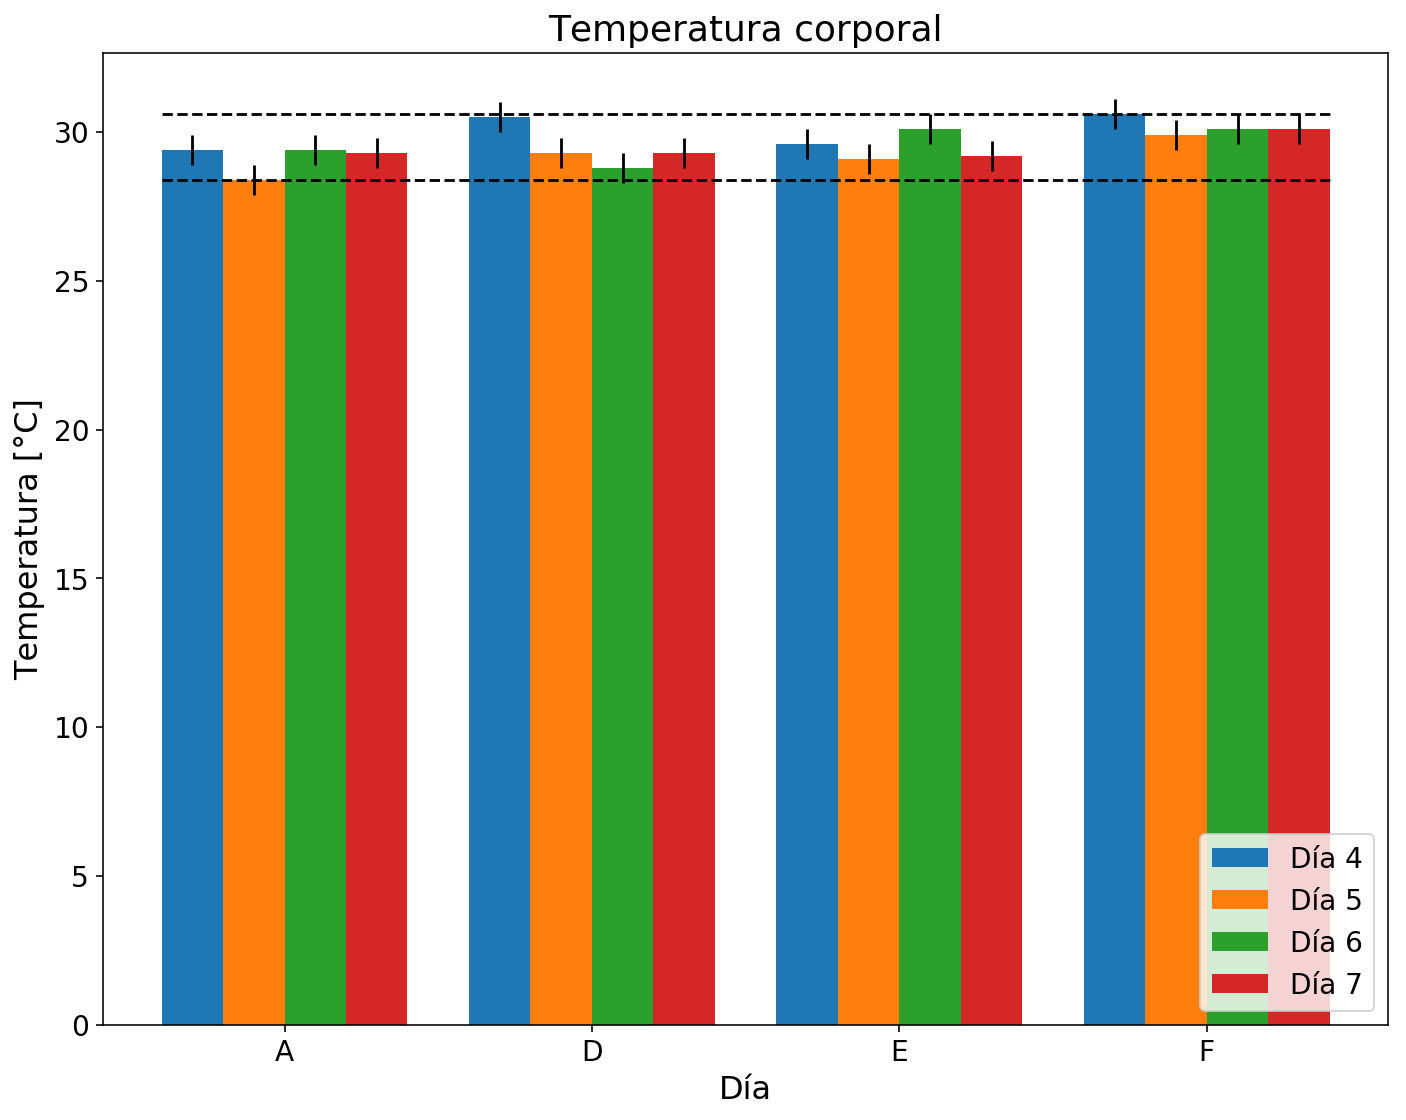

In [51]:
x = np.arange(len(etiquetas))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(10,8))
rects1 = ax.bar(x - 3*width/2, dia28, width, yerr=0.5, label='Día 4')
rects2 = ax.bar(x - width/2, dia29, width, yerr=0.5, label = "Día 5")#, label='Ox comercial')
rects3 = ax.bar(x + width/2, dia30, width, yerr=0.5, label = "Día 6")#, label='Ox comercial')
rects4 = ax.bar(x + 3*width/2, dia31, width, yerr=0.5, label = "Día 7")#, label='Ox comercial')
ax.plot([min(x)- 2*width, max(x)+ 2*width] , [minima_temp ,minima_temp], linestyle = "dashed", color="k")
ax.plot([min(x)- 2*width, max(x)+ 2*width] , [maxima_temp ,maxima_temp], linestyle = "dashed", color="k")
# plt.plot([0, 40], [ph1_promedio, ph1_promedio], linestyle="dashed")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Temperatura [°C]')
ax.set_xlabel('Día')
ax.set_title("Temperatura corporal")
ax.set_xticks(x)
ax.set_xticklabels(etiquetas)
ax.legend(loc="lower right")

def autolabel(rects, desv_est):
    """Attach a text label above each bar in *rects*, displaying its height."""
    i=0
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height)+"$\pm$"+str(desv_est[i]),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        i += 1

fig.tight_layout()
plt.show()    

In [52]:
# Independent two-sample T test: para comparar temperatura con SPO2
# Basado en: https://www.machinelearningplus.com/statistics/t-test-students-understanding-the-math-and-how-it-works/
def dist_t_ind(x1, x2, s1, s2):
    n1 = len(x1)
    n2 = len(x2)
    
    #Promedio primer vector
    acumulado_1 = 0
    for i in range(n1):
        acumulado_1 += x1[i]
    x1_prom= acumulado_1/n1

    #Promedio segundo vector
    acumulado_2 = 0
    for j in range(n2):
        acumulado_2 += x2[j]
    x2_prom = acumulado_2/n2

    numerador = x1_prom - x2_prom
    denominador = np.sqrt(s1**2/n1 + s2**2/n2)
    t = numerador/denominador
    
    print("Prueba T-Student de dos muestras independientes\n Promedio población 1: "
          +str(round(x1_prom, 1))+"±"+str(round(s1, 1))+"\n Promedio población 2: "
          +str(round(x2_prom, 1))+"±"+str(round(s2, 1))+"\n Así que hay un valor t de: "+str(t))
    return t

# n=28

In [53]:
desv_ests = [desv_est_total_25A, desv_est_total_26A, desv_est_total_27A, desv_est_total_28A,
             desv_est_total_29A, desv_est_total_30A, desv_est_total_31F,
             desv_est_total_25D, desv_est_total_26D, desv_est_total_27D, desv_est_total_28D,
             desv_est_total_29D, desv_est_total_30D, desv_est_total_31E,
             desv_est_total_25E, desv_est_total_26E, desv_est_total_27E, desv_est_total_28E,
             desv_est_total_29E, desv_est_total_30E, desv_est_total_31E,
             desv_est_total_25F, desv_est_total_26F, desv_est_total_27F, desv_est_total_28F,
             desv_est_total_29F, desv_est_total_30F, desv_est_total_31F]
np.mean(desv_ests)

4.678571428571429

In [55]:
t_ox = dist_t_ind(promedios_4sujetos, oxc_4sujetos, np.mean(desv_ests), np.std(oxc_4sujetos))

Prueba T-Student de dos muestras independientes
 Promedio población 1: 99.9±4.7
 Promedio población 2: 94.6±1.1
 Así que hay un valor t de: 5.824109182862765


Prueba T-Student de dos muestras independientes
 Promedio población 1: 99.9±1.2
 Promedio población 2: 94.6±1.1
 Así que hay un valor t de: 17.171532793013533

In [56]:
t_temp = dist_t_ind(promedios_4sujetos, temperaturas_4sujetos, np.mean(desv_ests), np.std(temperaturas_4sujetos))

Prueba T-Student de dos muestras independientes
 Promedio población 1: 99.9±4.7
 Promedio población 2: 29.6±0.6
 Así que hay un valor t de: 78.43126809040174


Prueba T-Student de dos muestras independientes
 Promedio población 1: 99.9±1.2
 Promedio población 2: 30.2±2.4
 Así que hay un valor t de: 108.58042615970734

In [59]:
np.std(temperaturas_4sujetos)

0.5849345583054574

In [57]:
t_temp = dist_t_ind(oxc_4sujetos, temperaturas_4sujetos, np.std(oxc_4sujetos), np.std(temperaturas_4sujetos))

Prueba T-Student de dos muestras independientes
 Promedio población 1: 94.6±1.1
 Promedio población 2: 29.6±0.6
 Así que hay un valor t de: 258.3749053006384


In [60]:
from scipy import stats
# Vea: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html
#El detalle es que con este paquete no le puedes introducir la desviacion estandar de esos datos

In [61]:
stats.ttest_ind(promedios_4sujetos, oxc_4sujetos)

Ttest_indResult(statistic=16.86211046194307, pvalue=3.5681370277762156e-23)

In [62]:
stats.ttest_ind(promedios_4sujetos, temperaturas_4sujetos)

Ttest_indResult(statistic=124.78511686394437, pvalue=1.2975387690914212e-55)

In [63]:
stats.ttest_ind(oxc_4sujetos, temperaturas_4sujetos)

Ttest_indResult(statistic=119.21421675214914, pvalue=8.78792984327117e-55)